In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#path = os.path.join(os.path.join(os.getcwd(), os.pardir),"data")
file = '../../data-20240427T110720Z-001\data\skylab_instagram_datathon_dataset.csv'
print(path)
#file = os.path.join(path, "skylab_instagram_datathon_dataset.csv")
data = pd.read_csv(file, delimiter=";")
data2 = pd.read_csv(file, delimiter=";")

../../data-20240427T110720Z-001\data\skylab_instagram_datathon_dataset.csv


# 1. Data Cleaning & Exploration

The data includes a lot of NaN values. We considered several approaches of dealing with such values and settled on linear interpolation. In that way, the general trends in the data are preserved and we don't throw away any useful data. Additionally, there often occurs the case, that there are NaN values at the beginning and the end of the time series data. In this case, we decided to throw away these datapoints, since it's hard to interpolate the ends without disturbing the general statistics of the data.

In [65]:
# Assuming 'data' is your DataFrame and 'metrics' is a list of columns to interpolate
def clean_dataframe(data, metrics, method: str="linear"):
    data = data.sort_values("period_end_date")
    companies = data["business_entity_doing_business_as_name"].unique()
    new = [None]*len(companies) 
    # Group by the company name and apply interpolation within each group
    for i in range(len(companies)):
        company = companies[i]
        company_idx = (data["business_entity_doing_business_as_name"] == company)
        filtered = data[company_idx]
        filtered[metrics] = filtered[metrics].interpolate(method=method)
        filtered = filtered.dropna()
        new[i] = filtered

    new_data = pd.concat(new, ignore_index=True)
    return new_data.sort_values("period_end_date")

data["period_end_date"] = pd.to_datetime(data["period_end_date"])

metrics = ["followers", "pictures", "likes", "videos", "comments"]
data = clean_dataframe(data, metrics)

C:\Users\Elias\AppData\Local\Temp\ipykernel_18592\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_18592\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_18592\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

## Data Counts

number companies:  52


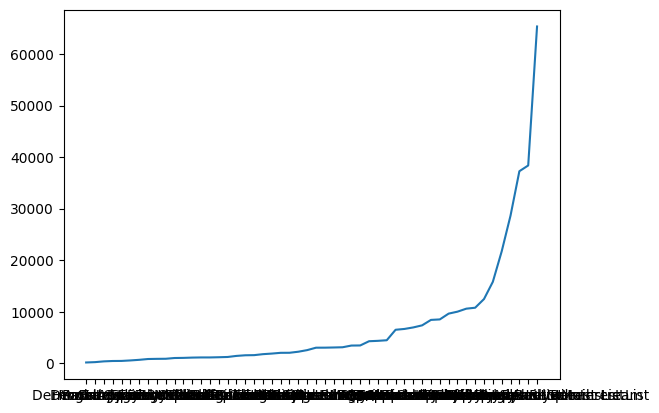

                                     entries   na
Global Luxury Analysts Interest List   21704  NaN
Beauty & Boutique                      28649  NaN
Apparel Retail                         37265  NaN
Luxury & Premium & Mainstream          38382  NaN
US Softlines Analyst Interest List     65354  NaN


In [66]:
import matplotlib.pyplot as plt

def count_entries(data: pd.DataFrame, column: str):
    cats = list(set(list(data["compset"])))
    print("number companies: ", len(cats))

    table = pd.DataFrame(columns=["entries", "na"], index=cats)
    for company in cats:
        data_company = data[data["compset"] == company]
        table.loc[company, "entries"] = len(data_company)
    table = table.sort_values(by=["entries"])
    return table

table = count_entries(data=data, column="compset")
plt.plot(table["entries"])
plt.show()
print(table[-5:])

## Yearly Means

C:\Users\Elias\AppData\Local\Temp\ipykernel_18592\2124670848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year


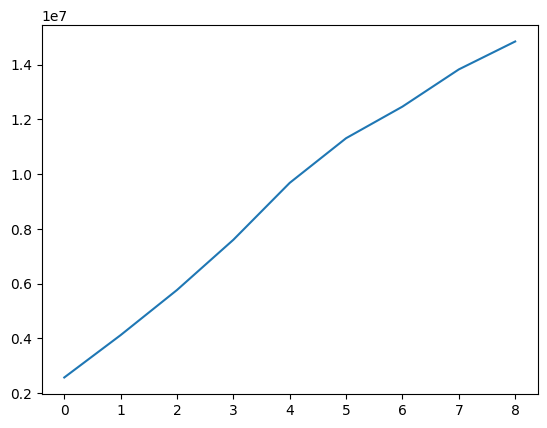

In [67]:
def calculate_yearly_means(df, col, category_column, category_value, period: str="yearly"):
    filtered_df = df[df[category_column] == category_value]
    
    # Convert the index to datetime if it's not already
    if period == "yearly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year
    elif period == "montly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.month

    yearly_means = filtered_df[col].groupby(filtered_df["time"]).mean()
    
    return yearly_means

yearly_means = calculate_yearly_means(data, "followers", "compset", "Soft Luxury", period="yearly")
plt.plot(range(len(yearly_means)), yearly_means)

# 2. Enrichment

To be able to work with more relevant data, we decided to transform our raw data into widely used marketing measures, which better represent the engagement of the customer with companies social media presence.


In [68]:
# Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / weekly_data['followers'] * 100

    # Calculate the like-to-comment ratio for each week
    # I actually think this feature does not make sense
    #weekly_data['like_to_comment_ratio'] = weekly_data['likes'] / (weekly_data['comments'] + 0.001)

    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate the virality rate for each week
    # Virality rate = (engagement per post this week / average engagement per post baseline) * 100
    # weekly_data['virality_rate'] = (weekly_data['average_engagement_per_post'] / weekly_data['average_engagement_per_post'].mean()) * 100

    # Merge the calculated weekly metrics back to the original dataframe
    df = pd.merge(df, weekly_data[['period_end_date', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post']], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df

# Optionally, to check the results for a specific company, e.g., 'Nike'
nike_data = company_tables['Nike']
print(nike_data[['period_end_date', 'pictures', 'likes', 'comments', 'followers', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post']].head())


  period_end_date  pictures       likes  comments   followers  \
0      2015-01-10     465.0  39738612.0  321669.0  25299746.0   
1      2015-01-17     471.0  43148382.0  393432.0  26143731.0   
2      2015-01-24     447.0  40263060.0  383376.0  26851899.0   
3      2015-01-31     399.0  36760893.0  411510.0  27483940.0   
4      2015-02-07     423.0  36223413.0  444420.0  28077326.0   

   engagement_rate  average_likes_per_post  average_comments_per_post  
0       158.342621            84911.382668                 687.325454  
1       166.547820            89892.275224                 819.648292  
2       151.372668            88295.990579                 840.734998  
3       135.251361            90100.007108                1008.600469  
4       130.595887            84436.663318                1035.941641  


In [69]:
enriched_data = pd.concat(company_tables.values(), ignore_index=True)

company_tables.keys()

dict_keys(['24S', '3CE', 'A. Lange & Soehne', 'ANIMALE', 'Abercrombie & Fitch', 'Absolut', 'Academy Sports + Outdoors', 'Adidas', 'Aerie', 'Alexander McQueen', 'Alexandre Birman', 'Allbirds', 'Alme', 'Alpro', 'American Eagle', 'Amstel', 'Anacapri', 'Anta', 'Antarctica', 'Aperol', 'Arezzo', 'Aritzia', 'Armani Beauty', 'Asics', 'Asos', 'Athleta', 'Atkins', 'Aveda', "BJ's Restaurant & Brewhouse", 'Balenciaga', 'Banana Republic', 'Bath & Body Works', 'Baw Clothing', 'Becca', "Beck's", 'Benefit', 'Bershka', 'Beyond Meat', 'Big Lots', 'Blancpain', 'Blue Buffalo', 'Bo.Bo', 'Bobbi Brown', 'Boca', 'Boohoo', 'Boot Barn', 'Boozt', 'Boral', 'Boss', 'Bottega Veneta', 'Brahma', 'Breguet', 'Breville', 'Brunello Cucinelli', 'Buckle', 'Budweiser', 'Build A Bear', 'Buitoni', 'Bulgari', 'Bulgari Beauty', 'Bumble and bumble', 'Burberry', 'Burberry Beauty', 'Burger King', 'Burlington Coat Factory', 'C&A Brasil', 'CCC Shoes', 'CEMEX', 'COS', 'CSR', 'Calvin Klein', 'CamelBak', 'Canada Goose', 'Carol Bassi', 

# 3. Modelling


In [70]:
def average_table(df, category_column, interesting_period, features, period: str="yearly"):
    cats = df[category_column].unique()
    table = pd.DataFrame(columns=features, index=cats)
    
    if period == "yearly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.year
    elif period == "monthly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.month

    df = df[df["time"] == interesting_period]

    for cat in cats:
        df_cat = df[df[category_column] == cat]
        for col in features:
            table.loc[cat, col] = np.nanmean(df_cat[col])
     
    return table.dropna() #?? 

features = ['pictures','likes', 'comments', 
            'followers', 'engagement_rate', 'average_likes_per_post', 
            'average_comments_per_post']
table = average_table(enriched_data, "business_entity_doing_business_as_name", 2020, features)
print(table.head())

C:\Users\Elias\AppData\Local\Temp\ipykernel_18592\2015003947.py:15: RuntimeWarning: Mean of empty slice
  table.loc[cat, col] = np.nanmean(df_cat[col])


                       pictures           likes     comments       followers  \
24S                   89.230769         47976.0  1356.692308   110612.230769   
3CE                  117.192308   651176.711538  1070.923077  1871147.903846   
A. Lange & Soehne    109.346154   128463.461538   951.192308   410998.923077   
ANIMALE               46.576923   141860.057692  3066.057692       1352757.5   
Abercrombie & Fitch  231.923077  2261130.634615  8451.173077  4945072.442308   

                    engagement_rate average_likes_per_post  \
24S                       44.510322             513.012566   
3CE                       35.082883             5187.15488   
A. Lange & Soehne         31.446975             1013.93454   
ANIMALE                   10.743849            2564.300195   
Abercrombie & Fitch        45.97853            9390.941189   

                    average_comments_per_post  
24S                                 14.317654  
3CE                                  8.280984  
A.

We need to first scale our dataframe to ensure that no feature weighs too much compared to others and skew the centroids of our kmeans

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
table_scaled = pd.DataFrame(scaler.fit_transform(table), columns = table.columns, index = table.index ) #scale data

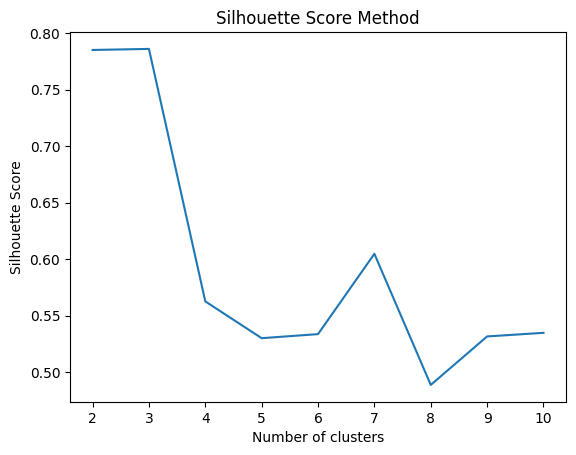

In [72]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_silhouette_scores(df):
    silhouette_scores = []

    # Example using the same dataset as above
    for i in range(2, 11):  # Silhouette score cannot be computed with only one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

relevant_features = ['followers', 'engagement_rate', 'average_likes_per_post', 'average_comments_per_post'] 
rel_table = table_scaled[relevant_features]
table= table[relevant_features]
rel_table = rel_table.div(rel_table.max())
silhouette_scores = kmeans_silhouette_scores(rel_table)
# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Clustering Parameters

From our first subset of variables, 5 seems like a useful amount of clusters. 
In the silhouette score plot, one can see how well different amounts of clusters fit ou
r data. 5 seems like a good fit since it looks like a local minimum after a steep drop. This minimizes the mean, while keeping the variance modest.

In [73]:
n_clusters = 5

In [104]:
def apply_kmeans_clustering(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)
    return df, kmeans

def get_outliers(df, model):
    df["dist"] = np.min(model.transform(df), axis=1)
    df = df.sort_values(by=["dist"])
    df["label"] = model.labels_
    return df[-10:]

rel_table, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)
centers = pd.DataFrame(data=model.cluster_centers_, columns=rel_table.columns)

""" for label in range(1,7):
    tabel_with_label = table[model.labels_ == label]
    plt.scatter(tabel_with_label["videos"], tabel_with_label["pictures"])
 """
outliers_table = get_outliers(rel_table, model)
for _, outlier in outliers_table.iterrows():
    print("profile:", outlier)
    print("cluster:", centers.loc[outlier["label"]])
idx = outliers_table.index
print(idx)


profile: followers                    0.552422
engagement_rate             -0.051711
average_likes_per_post       0.019575
average_comments_per_post    0.003728
dist                         0.322339
label                        0.000000
Name: Adidas, dtype: float64
cluster: followers                   -0.011629
engagement_rate             -0.022054
average_likes_per_post      -0.020175
average_comments_per_post   -0.011052
dist                         0.039744
Name: 0, dtype: float64
profile: followers                    1.000000
engagement_rate             -0.059617
average_likes_per_post       0.289533
average_comments_per_post    0.061054
dist                         0.322339
label                        0.000000
Name: Nike, dtype: float64
cluster: followers                   -0.011629
engagement_rate             -0.022054
average_likes_per_post      -0.020175
average_comments_per_post   -0.011052
dist                         0.039744
Name: 0, dtype: float64
profile: followers      

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

_, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)

y = label_binarize(model.labels_, classes = [1,2,3,4,5,6])
clf=RandomForestClassifier()
clf.fit(table, y)


RandomForestClassifier()

<class 'numpy.ndarray'>
(446, 7, 12)
bla
(446, 7)


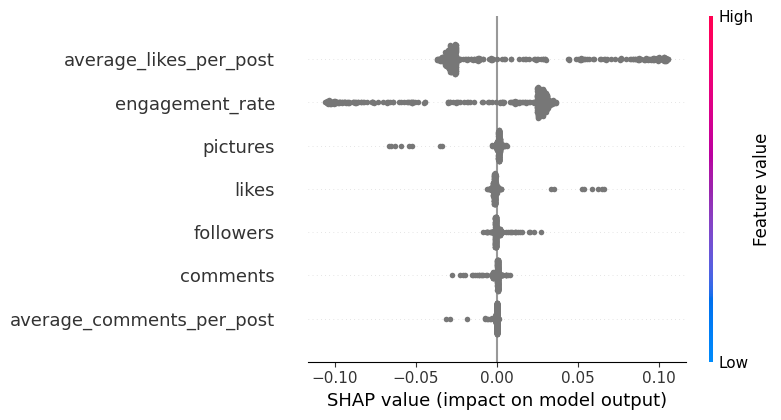

In [121]:
import shap

explainer = shap.TreeExplainer(clf)

shap_values = explainer(table).values

print(type(shap_values))

if isinstance(shap_values, list):  # Likely a multi-class classification model
    print([np.array(x).shape for x in shap_values])
else:  # For binary classification or regression
    print(np.array(shap_values).shape)
    print("bla")


class_index = 4
shap_values_class = shap_values[:, class_index, :]
print(table.shape)

shap.summary_plot(shap_values_class[:5000, :7], table.iloc[:5000, :7])

In [105]:
from sklearn.svm import OneClassSVM

model= OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.05 ).fit(rel_table)

y_pred = model.predict(rel_table)

anomaly_values = rel_table.iloc[np.where(y_pred == -1)]
print(anomaly_values)

                           followers  engagement_rate  average_likes_per_post  \
ANIMALE                    -0.013961        -0.054797               -0.019066   
Absolut                    -0.016408        -0.045448               -0.028630   
Academy Sports + Outdoors  -0.019285        -0.067739               -0.028814   
Adidas                      0.552422        -0.051711                0.019575   
Alexandre Birman           -0.018518        -0.035726               -0.024982   
...                              ...              ...                     ...   
YOOX                       -0.017942        -0.021001               -0.025804   
YesStyle                   -0.015052         0.842151                0.012197   
Yoplait                    -0.019612        -0.063810               -0.030191   
Yves Veggie Cuisine        -0.019952        -0.059849               -0.029869   
bareMinerals               -0.013681        -0.061846               -0.028273   

                           

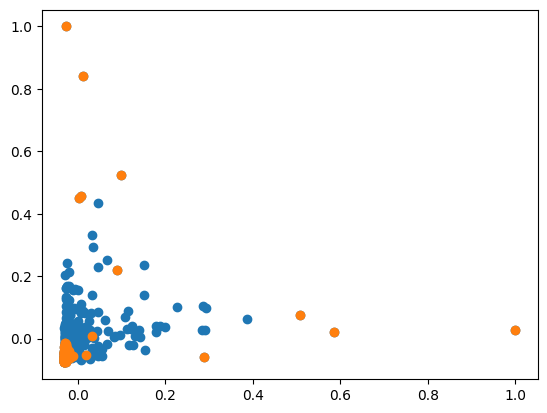

In [106]:
plt.scatter(rel_table["average_likes_per_post"], rel_table["engagement_rate"])
plt.scatter(anomaly_values["average_likes_per_post"], anomaly_values["engagement_rate"])